# k-Nearest Neighbors

k-Nearest Neighbors is a nonparametric model. The idea is simple:

* choose hyperparameter $k\in\mathbb N$;
* choose a distance metric in $\mathbb R^d$ (for example, Euclidean);
* for a sample $\boldsymbol x \in \mathbb R^d$ find its $k$ nearest neighbors among the training dataset;
* classify or predict the label of $\boldsymbol x$ according to the labels of its neighbors.

## Distance in $\mathbb R^d$

How to calculate distance $\rho (\boldsymbol x, \boldsymbol y)$ of vectors $\boldsymbol x, \boldsymbol y \in\mathbb R^d$?

* Euclidean distance: $\rho_2(\boldsymbol x, \boldsymbol y) = \sqrt{\sum\limits_{i=1}^d (x_i - y_i)^2}$
* Manhattan distance: $\rho_1(\boldsymbol x, \boldsymbol y) = \sum\limits_{i=1}^d |x_i - y_i|$
* Minkowski distance: $\rho_p(\boldsymbol x, \boldsymbol y) = \Big(\sum\limits_{i=1}^d |x_i - y_i|^p \Big)^{\frac 1p}$, $p \geqslant 1$

```{note}
The distance to zero vector $\rho_p(\boldsymbol x, \boldsymbol 0)$ is called **$p$-norm**:

$$
    \| \boldsymbol x \|_p = \Big(\sum\limits_{i=1}^d |x_i|^p \Big)^{\frac 1p}
$$

The **unit ball** in $\mathbb R^d$ with respect to $p$-norm is defined as

$$
    \{\boldsymbol x \in \mathbb R^d \colon \|\boldsymbol x\|_p \leqslant 1\}.
$$
```

In [6]:
import numpy as np
import plotly.graph_objects as go

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, to_hex

deep_grey = '#3B4856' # основной тёмный / холодный цвет
sky_blue = '#348FEA'
marine_green = '#4CB9C0'
grass_green = '#97C804'
medium_yellow = '#FFC100' # основной светлый / тёплый цвет
sicilian_orange = '#E06A27'
fuchsia_pink = '#C81D6B'
saturated_violet = '#5002A7'
navy_blue = '#292183'
cool_white = '#F5FBFF' # нужен, чтобы "очень светлый фон" выделялся на фоне белого фона страницы

# Создадим бинарную палитру: класс 0 -- серый, класс 1 -- жёлтый
cmap_yg_binary = ListedColormap([deep_grey, medium_yellow])

# Создадим непрерывную палитру: класс 0 -- серый, класс 1 -- жёлтый
cmap_yg_continuous = LinearSegmentedColormap.from_list(
    'yandex_linear_cm', list(zip([0.0, 1.0], [deep_grey, medium_yellow]))
)

many_colors = [deep_grey, sky_blue, marine_green, grass_green, medium_yellow,
    sicilian_orange, fuchsia_pink, saturated_violet, navy_blue, cool_white]

def plot_slider_minkowski(ps, write_html=False):
    fig = go.Figure()
    p_inf = 500
    ts = np.linspace(0, np.pi/2, num=200)
    for i, p in enumerate(ps):
        if p == "∞":
            p = p_inf
        xs = np.cos(ts) ** (2/p)
        xs_full = np.hstack([xs, -xs[::-1], -xs, xs[::-1]])
        ys = np.sin(ts) ** (2/p)
        ys_full = np.hstack([ys, ys[::-1], -ys, -ys[::-1]])
        fig.add_trace(
            go.Scatter(
                x=xs_full,
                y=ys_full,
                name=f"p={ps[i]}",
                visible=False,
                line=dict(color=to_hex(cmap_yg_continuous(i / len(ps))), width=3),
                fill="tozeroy",
            )
        )

    fig.update_layout(
                      width=600,
                      title={"text": "Minkowski unit disk", "x": 0.5},
                      xaxis=dict(title="x"),
                      yaxis=dict(title="y", scaleanchor="x", scaleratio=1),
                      margin=dict(t=50))
    
    fig.add_vline(0)
    fig.add_hline(0)
    
    fig.data[len(ps) // 2].visible = True

    # Create and add slider
    steps = []
    for i in range(len(fig.data)):
        step = dict(
            method="update",
            args=[
                {"visible": [False] * len(fig.data)},
            ],  # layout attribute
            label = ps[i]
        )
        step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
        steps.append(step)

    sliders = [dict(
        active=len(ps) // 2,
        pad={"t": 50},
        currentvalue={"prefix": r"p="}, 
        steps=steps
    )]
        
    fig.update_layout(
        sliders=sliders,
    )
    if write_html:
        fig.write_html("slider_minkowski.html", full_html=False, include_plotlyjs='cdn', include_mathjax='cdn')
    fig.show()

In [7]:
plot_slider_minkowski([0.67, 0.8, 1, 1.2, 1.4, 1.5,  1.6, 1.8, 2, 2.2, 2.5, 3, 4, 5, 7, 10, "∞"], write_html=True)

**Q**. The "infinite" norm is defined as 

$$
    \| \boldsymbol x \|_\infty = \lim\limits_{p\to +\infty} \| \boldsymbol x \|_p. 
$$

What is the value of $\lim\limits_{p\to +\infty} \Big(\sum\limits_{i=1}^d |x_i|^p \Big)^{\frac 1p}$?

## k-NN algorithm

```{figure} https://cdn.analyticsvidhya.com/wp-content/uploads/2018/03/knn3.png
:align: center
:width: 400px
```

Given the training dataset $\{(\boldsymbol x_i, y_i)\}_{i=1}^n$, how to classify a new object $\boldsymbol x$?

1. Sort distances $\rho (\boldsymbol x_i, \boldsymbol x)$ in increasing order:

    $$
    \rho (\boldsymbol x_{(1)}, \boldsymbol x) \leqslant \rho (\boldsymbol x_{(2)}, \boldsymbol x) \leqslant \ldots \leqslant \rho (\boldsymbol x_{(n)}, \boldsymbol x) 
    $$

2. So $\boldsymbol x_{(i)}$ is the $i$-th neighbor of the object $\boldsymbol x$

3. Let $y_{(i)}$ be the label of $\boldsymbol x_{(i)}$

4. The label $\hat y$ of the object $\boldsymbol x\in\mathbb R^d$ is set to the most common label among $k$ neighbors of $\boldsymbol x$:

$$
    \widehat y = \arg\max_{y\in Y} \sum\limits_{i=1}^k [y = y_{(i)}]
$$

For regression task the last step is subsituted by 

$$
    \widehat y = \frac 1k\sum\limits_{i=1}^k y_{(i)}.
$$

Note that $\widehat y = y_{(1)}$ if $k=1$.

### Voronoi tessellation

A k-NN classifier with $k=1$ induces a **Voronoi tessellation** of the points.
This is a partition of space which associates a region $V(\boldsymbol x_i)$ with each sample $\boldsymbol x_i$ in such a way that all points in $V(\boldsymbol x_i)$ are closer to  $\boldsymbol x_i$ than to any other point. In other words,

$$
    V(\boldsymbol x_i) = \{\boldsymbol z \in \mathbb R^n\colon \rho(\boldsymbol x_i, \boldsymbol z) < \rho(\boldsymbol x_j, \boldsymbol z) \text{ for all }j\ne i\}.
$$

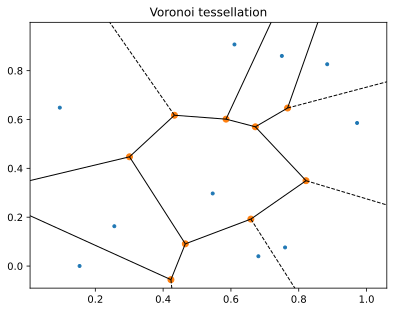

In [13]:
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt

%config InlineBackend.figure_formats = ['svg']

n = 10
points = np.random.rand(n, 2)
vor = Voronoi(points)
fig = voronoi_plot_2d(vor)
plt.title("Voronoi tessellation");

<span style="display:none" id="q_1nn_train_loss">W3sicXVlc3Rpb24iOiAiU3VwcG9zZSB3ZSBhcmUgdHJhaW5pbmcgJDEkLU5OIGFsZ29yaXRobSB1c2luZyBtaXNjbGFzc2lmaWNhdGlvbiByYXRlIGFzIHRoZSBsb3NzIGZ1bmN0aW9uLiBXaGF0IHdpbGwgYmUgdGhlIHRyYWluIGVycm9yPyIsICJ0eXBlIjogIm51bWVyaWMiLCAiYW5zd2VycyI6IFt7InR5cGUiOiAidmFsdWUiLCAidmFsdWUiOiAwLCAiY29ycmVjdCI6IHRydWUsICJmZWVkYmFjayI6ICJSaWdodCBvbiEgQWxsIHRyYWluaW5nIHBvaW50cyB3aWxsIGJlIGNsYXNzaWZpZWQgY29ycmVjdGx5In0sIHsidHlwZSI6ICJyYW5nZSIsICJyYW5nZSI6IFstMTAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMCwgMF0sICJmZWVkYmFjayI6ICJNaXNjbGFzc2lmaWNhdGlvbiByYXRlIG11c3QgYmUgYmV0d2VlbiAwIGFuZCAxIn0sIHsidHlwZSI6ICJyYW5nZSIsICJyYW5nZSI6IFsxLjAwMDAwMDAwMDEsIDEwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDBdLCAiZmVlZGJhY2siOiAiTWlzY2xhc3NpZmljYXRpb24gcmF0ZSBtdXN0IGJlIGJldHdlZW4gMCBhbmQgMSJ9LCB7InR5cGUiOiAiZGVmYXVsdCIsICJmZWVkYmFjayI6ICJObywgdGhpcyBpcyBub3QgdHJ1ZSJ9XX1d</span>

In [43]:
from jupyterquiz import display_quiz
display_quiz("#q_1nn_train_loss")

<IPython.core.display.Javascript object>

## Role of $k$

The decision boundaries become smoother as $k$ grows. Here is an example from {cite:p}`pml1Book` (figure 16.2): k-NN algorithm is applied to simulated data with three clusters.

```{figure} ./Murphy_16_2.png
:align: center
```

**Q.** Look at the graph of train and test errors. For which values of $k$ we can suspect overfitting?

```{admonition} Effective number of parameters of $k$-NN
:class: note, dropdown
It is equal to $\frac n k$. To get an idea of why, note that if the neighborhoods were nonoverlapping, there would be $\frac nk$ neighborhoods and we would fit one parameter (a mean) in each neighborhood ({cite:p}`hastie2009elements`, p. 14)
```

## Curse of dimensionality

```{figure} https://www.researchgate.net/publication/347363976/figure/fig4/AS:970060722089985@1608291907488/Geometry-for-the-computation-of-the-volume-of-the-slice-We-ideally-slice-the-large-piece.png
:align: center
```
Only red part of watermelon is useful, and watermelon rind is thrown away. Suppose that the watermelon is a ball of radius $R$, and the length of the rind is $10\%$ of $R$. 

<span style="display:none" id="watermelon">W3sicXVlc3Rpb24iOiAiV2hhdCBwZXJjZW50YWdlIG9mIHRoZSB3YXRlcm1lbG9uIGlzIGVhdGFibGU/IiwgInR5cGUiOiAibnVtZXJpYyIsICJhbnN3ZXJzIjogW3sidHlwZSI6ICJ2YWx1ZSIsICJ2YWx1ZSI6IDAuNzI5LCAiY29ycmVjdCI6IGZhbHNlLCAiZmVlZGJhY2siOiAiVGhpcyBpcyB0aGUgcGFydCB3cml0dGVuIGFzIGRlY2ltYWwgZnJhY3Rpb24ifSwgeyJ0eXBlIjogInZhbHVlIiwgInZhbHVlIjogNzIuOSwgImNvcnJlY3QiOiB0cnVlLCAiZmVlZGJhY2siOiAiVGhhdCdzIGNvcnJlY3QhICQoMC45KV4zXFx0aW1lcyAxMDBcXCUgPSA3Mi45XFwlJCJ9LCB7InR5cGUiOiAicmFuZ2UiLCAicmFuZ2UiOiBbLTEwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwLCAwXSwgImZlZWRiYWNrIjogIlBlcmNlbnRhZ2UgY2Fubm90IGJlIG5lZ2F0aXZlIn0sIHsidHlwZSI6ICJyYW5nZSIsICJyYW5nZSI6IFsxMDAuMDAwMDAwMDAwMSwgMTAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDBdLCAiZmVlZGJhY2siOiAiWW91IGNhbm5vdCBlYXQgbW9yZSB0aGF0ICQxMDBcXCUkIG9mIHRoZSB3YXRlcm1lbG9uIn0sIHsidHlwZSI6ICJkZWZhdWx0IiwgImZlZWRiYWNrIjogIk5vLCB0aGlzIGlzIG5vdCB0cnVlIn1dfSwgeyJxdWVzdGlvbiI6ICJIb3cgdGhlIGFuc3dlciB3b3VsZCBjaGFuZ2UgaWYgd2Ugd2VyZSBsaXZpbmcgaW4gJFxcbWF0aGJiIFJeezEwfSQ/IiwgInR5cGUiOiAibnVtZXJpYyIsICJhbnN3ZXJzIjogW3sidHlwZSI6ICJyYW5nZSIsICJyYW5nZSI6IFswLjM0OCwgMC4zNDkxXSwgImNvcnJlY3QiOiBmYWxzZSwgImZlZWRiYWNrIjogIlRoaXMgaXMgdGhlIHBhcnQgd3JpdHRlbiBhcyBkZWNpbWFsIGZyYWN0aW9uIn0sIHsidHlwZSI6ICJyYW5nZSIsICJyYW5nZSI6IFszNC44LCAzNC45MV0sICJjb3JyZWN0IjogdHJ1ZSwgImZlZWRiYWNrIjogIlRoYXQncyBjb3JyZWN0ISAkKDAuOSleezEwfVxcdGltZXMgMTAwXFwlIFxcYXBwcm94IDM0LjlcXCUkIn0sIHsidHlwZSI6ICJyYW5nZSIsICJyYW5nZSI6IFstMTAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAsIDBdLCAiY29ycmVjdCI6IGZhbHNlLCAiZmVlZGJhY2siOiAiUGVyY2VudGFnZSBjYW5ub3QgYmUgbmVnYXRpdmUifSwgeyJ0eXBlIjogInJhbmdlIiwgInJhbmdlIjogWzEwMC4wMDAwMDAwMDAxLCAxMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMF0sICJjb3JyZWN0IjogZmFsc2UsICJmZWVkYmFjayI6ICJZb3UgY2Fubm90IGVhdCBtb3JlIHRoYXQgJDEwMFxcJSQgb2YgdGhlIHdhdGVybWVsb24ifSwgeyJ0eXBlIjogImRlZmF1bHQiLCAiZmVlZGJhY2siOiAiRmFsc2UifV19XQ==</span>

In [23]:
display_quiz("#watermelon")

<IPython.core.display.Javascript object>

This is how the **curse of dimensionality** works. In $50$-dimensional space there is almost nothing to eat in a watermelon.

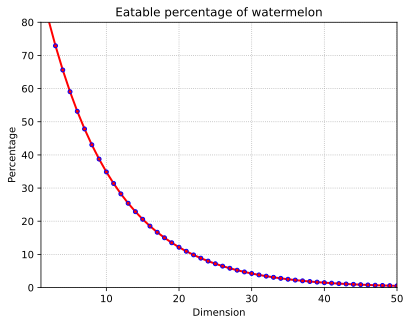

In [35]:
n_max = 50
ns = np.arange(1, n_max + 1)
p = 0.9
plt.plot(ns, 100*p**ns, lw=2, c='r', marker='o', markeredgecolor='b', markersize=4)
plt.ylim(0, 80)
plt.xlim(1, n_max)
plt.title("Eatable percentage of watermelon")
plt.xlabel("Dimension")
plt.ylabel("Percentage")
plt.grid(ls=":")

What are the consequenes of curse of the dimensionality for $k$-NN?

```{admonition} A common example from textbooks
Suppose we apply a $k$-NN classifier to data where the inputs are uniformly distributed in the $d$-dimensional unit cube. Suppose we estimate the density of class labels around a test point $\boldsymbol x$ by "growing" a hyper-cube around $\boldsymbol x$ until it contains a desired fraction $p$ of the data points. The expected edge length of this cube will be $e_d(p)=p^{\frac 1d}$ (see {cite:p}`pml1Book`, p. 530-531). For example, if $d=10$ and we want to capture $1\%$ of neighbours, we need extend the cube $e_{10}(0.01) \approx 0.63$ along each dimension around $\boldsymbol x$.
```

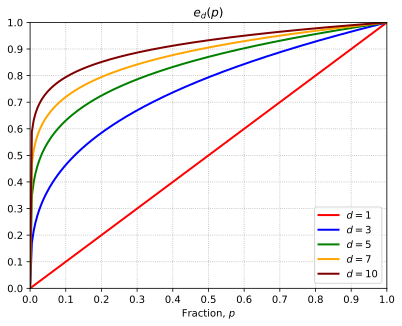

In [42]:
ps = np.linspace(0, 1, num=201)
ds = [1, 3, 5, 7, 10]
colors = ['r', 'b', 'g', 'orange', 'maroon']
for i, d in enumerate(ds):
    plt.plot(ps, ps**(1./d), lw=2, c=colors[i], label=f"$d={d}$")

plt.ylim(0, 1)
plt.xlim(0, 1)
plt.title(r"$e_d(p)$")
plt.xlabel("Fraction, $p$")
plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))
plt.legend()
plt.grid(ls=":")

```{admonition} TODO
:class: warning
* Make the last plot interactive
* Apply k-NN to some real datasets
* Add a plot and quiz on manual calculations with nearest neighbors
```